In [13]:
import pandas as pd
import os
import numpy as np
import datetime
import chardet
import time
from matplotlib import pyplot as plt
from collections import Counter
from itertools import combinations

In [14]:
soot_results = pd.read_csv('soot-results.csv', sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)
loi = pd.read_csv('LOI.csv', sep=';', encoding='latin-1', on_bad_lines='skip', low_memory=False)

In [15]:
def get_loi(project, class_name,  method, merge_commit):

        filter_scenario = (loi['Project'] == str(project)) & (loi['Merge Commit'] == str(merge_commit)) & (loi['Class Name'] == str(class_name)) & (loi['Method or field declaration changed by the two merged branches'] == str(method))
        value_LOI = ""

        if filter_scenario.any():
            value_LOI = loi.loc[filter_scenario, 'Locally Observable Interference'].values[0]

        return value_LOI

In [16]:
info_LOI = ['project', 'class', 'method', 'merge commit']

list_values = soot_results.columns.tolist()
remove_columns = ['project', 'class', 'method', 'merge commit', 'Time']
analysis = [coluna for coluna in list_values if coluna not in remove_columns]

In [17]:
left_right_analysis = list(set([x.replace("left right ", "") for x in analysis if "left right " in x]))
analysis_name = list(set([x.replace("left right ", "").replace("right left ", "") for x in analysis]))

In [18]:
def get_name_analysis(list_name):
    names = []
    for i in list_name:
        if (i in left_right_analysis):
            names.append("left right "+i)
            names.append("right left "+i)
        else:
            names.append(i)
    return names

def get_reverse_name(lists):
    names = []
    for elem_list in lists:
        aux_list = []
        for i in elem_list:
            if "left right" in i:
                aux_list.append(i.replace("left right ", ""))
            elif ("right left " not in i):
                aux_list.append(i)
        names.append(aux_list)
    return names


In [19]:
# Lista dos elementos
elements = analysis_name
combinations_list = []
# Gerar todas as combinações possíveis de 2 a 4 elementos sem repetições
for length in range(1, len(elements) + 1):
    for combination in combinations(elements, length):
        combinations_list.append(list(combination))

print(combinations_list)

# gerando todas as combinações possíveis

analysis_combination = []
for i in combinations_list:
    analysis_combination.append(get_name_analysis(i))
print(analysis_combination)

[['PDG-e'], ['Confluence Inter'], ['PDG'], ['DFP-Inter'], ['OA Inter'], ['CD'], ['DFP-Intra'], ['CDe'], ['Confluence Intra'], ['PDG-e', 'Confluence Inter'], ['PDG-e', 'PDG'], ['PDG-e', 'DFP-Inter'], ['PDG-e', 'OA Inter'], ['PDG-e', 'CD'], ['PDG-e', 'DFP-Intra'], ['PDG-e', 'CDe'], ['PDG-e', 'Confluence Intra'], ['Confluence Inter', 'PDG'], ['Confluence Inter', 'DFP-Inter'], ['Confluence Inter', 'OA Inter'], ['Confluence Inter', 'CD'], ['Confluence Inter', 'DFP-Intra'], ['Confluence Inter', 'CDe'], ['Confluence Inter', 'Confluence Intra'], ['PDG', 'DFP-Inter'], ['PDG', 'OA Inter'], ['PDG', 'CD'], ['PDG', 'DFP-Intra'], ['PDG', 'CDe'], ['PDG', 'Confluence Intra'], ['DFP-Inter', 'OA Inter'], ['DFP-Inter', 'CD'], ['DFP-Inter', 'DFP-Intra'], ['DFP-Inter', 'CDe'], ['DFP-Inter', 'Confluence Intra'], ['OA Inter', 'CD'], ['OA Inter', 'DFP-Intra'], ['OA Inter', 'CDe'], ['OA Inter', 'Confluence Intra'], ['CD', 'DFP-Intra'], ['CD', 'CDe'], ['CD', 'Confluence Intra'], ['DFP-Intra', 'CDe'], ['DFP-Intr

In [20]:
def calculate_matrix(columns):
    results = []
    for index, row in soot_results.iterrows():
        values = [row[column] for column in columns]
        actual_loi = get_loi(row['project'], row['class'], row['method'], row['merge commit'])
        or_value = any(value != 'false' for value in values)
        result = ""
        # print("OR:", or_value, "LOI:", actual_loi)
        if or_value == True and actual_loi == 'Yes':
            result = "TRUE POSITIVE"
        elif or_value == False and actual_loi == 'No':
            result = "TRUE NEGATIVE"
        elif or_value == False and actual_loi == 'Yes':
            result = "FALSE NEGATIVE"
        elif or_value == True and actual_loi == 'No':
            result = "FALSE POSITIVE"
        if actual_loi != "-":
            results.append(result)
    return results

In [21]:
def count_fp_fn(list_result):
    # Criar um contador dos elementos da lista
    element_count = Counter(list_result)

    result = []
    # Imprimir a contagem de elementos repetidos
    for element, count in element_count.items():
        if count > 1:
            result.append((str(element)+": "+str(count)))
    return result

In [22]:
class Longest:
    maiorPrecision = -1.0
    maiorRecall = -1.0
    maiorF1 = -1.0
    maiorAcuracia = -1.0
    mPrecision = []
    mRecall = []
    mF1 = []
    mAcuracia = []
    mPrecision_t = []
    mRecall_t = []
    mF1_t = []
    mAcuracia_t = []

    def __init__(self):
        self.maiorPrecision = -1.0
        self.maiorRecall = -1.0
        self.maiorF1 = -1.0
        self.maiorAcuracia = -1.0
        mPrecision = []
        mRecall = []
        mF1 = []
        mAcuracia = []
        mPrecision_t = []
        mRecall_t = []
        mF1_t = []
        mAcuracia_t = []


    def confusion_matrix(self, options, values_elem):

        # Inicializar as variáveis
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        
        # Extrair os valores dos elementos da lista
        for option in options:
            if "TRUE POSITIVE" in option:
                tp = int(option.split(': ')[1])
            elif "FALSE POSITIVE" in option:
                fp = int(option.split(': ')[1])
            elif "TRUE NEGATIVE" in option:
                tn = int(option.split(': ')[1])
            elif "FALSE NEGATIVE" in option:
                fn = int(option.split(': ')[1])
       
        # Calcular as métricas se todos os valores foram extraídos
        if tp is not None and fp is not None and tn is not None and fn is not None:
            if tp != 0 and fp != 0:
                precision = tp / (tp + fp)
            else:
                precision = 0.0

            if tp != 0 and fn != 0:
                recall = tp / (tp + fn)
            else:
                recall = 0.0

            if precision != 0 and recall != 0:
                f1_score = 2 * (precision * recall) / (precision + recall)
            else:
                f1_score = 0.0

            if tp != 0 and tn != 0 and fp != 0 and fn != 0:
                accuracy = (tp + tn) / (tp + tn + fp + fn)
            else:
                accuracy = 0.0

            if (precision > self.maiorPrecision):
                self.maiorPrecision = precision
                self.mPrecision = []
                self.mPrecision.append(values_elem)

            if (precision == self.maiorPrecision):
                if values_elem not in self.mPrecision:
                    self.mPrecision.append(values_elem)
                
            if (recall > self.maiorRecall):
                self.maiorRecall = recall
                self.mRecall = []
                self.mRecall.append(values_elem)

            if (recall == self.maiorRecall):
                if values_elem not in self.mRecall:
                    self.mRecall.append(values_elem)

                
            if (f1_score > self.maiorF1):
                self.maiorF1 = f1_score
                self.mF1 = []
                self.mF1.append(values_elem)

            if (f1_score == self.maiorF1):
                if values_elem not in self.mF1:
                    self.mF1.append(values_elem)
            
            if (accuracy > self.maiorAcuracia):            
                self.maiorAcuracia = accuracy
                self.mAcuracia = []
                self.mAcuracia.append(values_elem)

            if (accuracy == self.maiorAcuracia):
                if values_elem not in self.mAcuracia:
                    self.mAcuracia.append(values_elem)

            # Imprimir as métricas
            print(f"Precision: {precision:.2f}")
            print(f"Recall: {recall:.2f}")
            print(f"F1 Score: {f1_score:.2f}")
            print(f"Accuracy: {accuracy:.2f}")
                
            result_metrics = {
                "precision": precision,
                "recall": recall,
                "f1_score": f1_score,
                "accuracy": accuracy
            }
            return result_metrics
        else:
            print("Não foi possível extrair todos os valores necessários: ", tp, fp, tn, fn)

        return None


In [25]:
#Escolhendo qual o melhor resultado com base no Algoritmo de comparação
best = Longest()

for first in analysis_combination:
    print(first)      
    r_first = calculate_matrix(first)

    print("Combination:", count_fp_fn(r_first))
    best.confusion_matrix(count_fp_fn(r_first), first)
    print()

print(f"Precision: {best.maiorPrecision:.2f}", best.mPrecision)
print(f"Recall: {best.maiorRecall:.2f}", best.mRecall)
print(f"F1-score: {best.maiorF1:.2f}", best.mF1)
print(f"Accuracy: {best.maiorAcuracia:.2f}", best.mAcuracia)


['left right PDG-e', 'right left PDG-e']
Combination: ['FALSE POSITIVE: 22', 'TRUE POSITIVE: 19', 'TRUE NEGATIVE: 44', 'FALSE NEGATIVE: 14']
Precision: 0.46
Recall: 0.58
F1 Score: 0.51
Accuracy: 0.64

['Confluence Inter']
Combination: ['TRUE NEGATIVE: 51', 'FALSE NEGATIVE: 27', 'TRUE POSITIVE: 6', 'FALSE POSITIVE: 15']
Precision: 0.29
Recall: 0.18
F1 Score: 0.22
Accuracy: 0.58

['left right PDG', 'right left PDG']
Combination: ['FALSE POSITIVE: 15', 'TRUE POSITIVE: 14', 'TRUE NEGATIVE: 51', 'FALSE NEGATIVE: 19']
Precision: 0.48
Recall: 0.42
F1 Score: 0.45
Accuracy: 0.66

['left right DFP-Inter', 'right left DFP-Inter']
Combination: ['TRUE NEGATIVE: 47', 'FALSE NEGATIVE: 24', 'TRUE POSITIVE: 9', 'FALSE POSITIVE: 19']
Precision: 0.32
Recall: 0.27
F1 Score: 0.30
Accuracy: 0.57

['OA Inter']
Combination: ['TRUE NEGATIVE: 62', 'FALSE NEGATIVE: 29', 'TRUE POSITIVE: 4', 'FALSE POSITIVE: 4']
Precision: 0.50
Recall: 0.12
F1 Score: 0.20
Accuracy: 0.67

['left right CD', 'right left CD']
Combinat

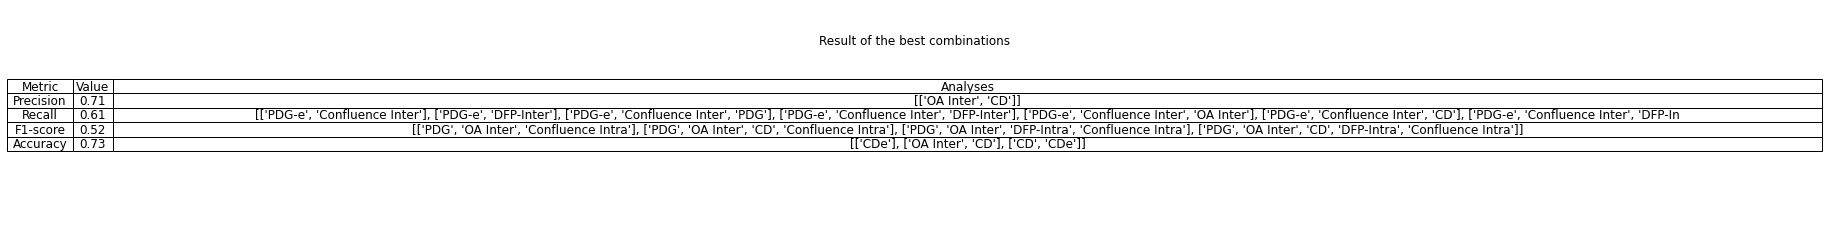

In [31]:
data = {
    'Metric': ['Precision', 'Recall', 'F1-score', 'Accuracy'],
    'Value': [round(best.maiorPrecision, 2), round(best.maiorRecall, 2), round(best.maiorF1, 2), round(best.maiorAcuracia, 2)],
   'Analyses': [str(get_reverse_name(best.mPrecision))[:255], 
                str(get_reverse_name(best.mRecall))[:255], 
                str(get_reverse_name(best.mF1))[:255], 
                str(get_reverse_name(best.mAcuracia))[:255]]
}
dframe = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=dframe.values, colLabels=dframe.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

for i, col in enumerate(dframe.columns):
    col_width = max([len(str(val)) for val in dframe[col]])
    table.auto_set_column_width(i)
    table.auto_set_column_width(col_width)

plt.title("Result of the best combinations", y=0.8)

plt.savefig('best_combinations.jpg', dpi=300, bbox_inches='tight', pad_inches=0.5)



In [36]:
data = {
    'Metric': ['Precision', 'Recall', 'F1-score', 'Accuracy'],
    'Value': [round(best.maiorPrecision, 2), round(best.maiorRecall, 2), round(best.maiorF1, 2), round(best.maiorAcuracia, 2)],
   'Analyses': [str(get_reverse_name(best.mPrecision)), 
                str(get_reverse_name(best.mRecall)), 
                str(get_reverse_name(best.mF1)), 
                str(get_reverse_name(best.mAcuracia))]
}
dframe = pd.DataFrame(data)

nome_arquivo = "best_combinations.csv"

dframe.to_csv(nome_arquivo, sep=';', index=False)



In [41]:
df_t = pd.read_csv('miningframework/output/results/times/resultTime-1.csv', sep=';', encoding='utf-8', on_bad_lines='skip', low_memory=False)


In [38]:
def sum_n_esimo_element(lista_de_listas, n):
    return sum(sublista[n] for sublista in lista_de_listas)

def get_sum_all_list(all_list):
    return [sum_n_esimo_element(all_list, i) for i in range(len(all_list[0]))]

def get_total_time(list_analysis):
    result = []
    for column_analysis in list_analysis:
        actual_time = [i for i in df_t[column_analysis]]
        result.append(actual_time)
    return result

def get_mean(values):
    return pd.Series(get_sum_all_list(values)).mean()

def get_median(values):
    return pd.Series(get_sum_all_list(values)).median()

def get_sum(values):
    return pd.Series(get_sum_all_list(values)).sum()

def get_standard_desviation(values):
    return pd.Series(get_sum_all_list(values)).std()

In [39]:
def get_mean_metric(metric, config):
    metric_t = []
    for i in metric:
        aux_list = get_name_analysis_time(i, config)
        result = get_total_time(aux_list)
        value = round(pd.Series(get_mean(result)).sum(), 2)
        metric_t.append(value)
    return metric_t

def get_sum_metric(metric, config):
    metric_t = []
    for i in metric:
        aux_list = get_name_analysis_time(i, config)
        result = get_total_time(aux_list)
        value = round(pd.Series(get_sum(result)).sum(), 2)
        metric_t.append(value)
    return metric_t

def get_median_metric(metric, config):
    metric_t = []
    for i in metric:
        aux_list = get_name_analysis_time(i, config)
        result = get_total_time(aux_list)
        value = round(pd.Series(get_median(result)).sum(), 2)
        metric_t.append(value)
    return metric_t

def get_std_metric(metric, config):
    metric_t = []
    for i in metric:
        aux_list = get_name_analysis_time(i, config)
        result = get_total_time(aux_list)
        value = round(pd.Series(get_standard_desviation(result)).sum(), 2)
        metric_t.append(value)
    return metric_t


In [68]:
def get_name_analysis_time(list_name, config):
    names = []
    for i in list_name:
        if ("Confluence" in i):
            actual_name = i.replace("Confluence ", "Confluence 1 ")
            if config:
                names.append("Configure Soot "+actual_name)
            names.append("Time to perform "+actual_name)
            
            actual_name = i.replace("Confluence ", "Confluence 2 ")

            if config:
                names.append("Configure Soot "+actual_name)

            names.append("Time to perform "+actual_name)
            
        elif ("left right" in i):
            actual_name = i.replace("left right ", "")
            if ("DF" in i):
                actual_name = actual_name.replace("-", " ")
            else:
                actual_name = actual_name.replace("-", "")

            if config:
                names.append("Configure Soot "+actual_name+" left-right")
                names.append("Configure Soot "+actual_name+" right-left")
            names.append("Time to perform "+actual_name+" left-right")
            names.append("Time to perform "+actual_name+" right-left")
        elif ("right left" not in str(i)):
            if config:
                names.append("Configure Soot "+i)
            names.append("Time to perform "+i)

    return names

In [69]:

with_config = True

colums = df_t.columns

print("Analyzing", best.mPrecision)
mean_p = get_mean_metric(best.mPrecision, with_config)
median_p = get_median_metric(best.mPrecision, with_config)
# sum_p = get_sum_metric(best.mPrecision, with_config)
std_p = get_std_metric(best.mPrecision, with_config)

# out_precision = f"Mean: {mean_p} Median: {median_p} Sum: {sum_p} Standard: {std_p}"
out_precision = [mean_p, median_p, std_p]

print(out_precision)

print("Analyzing", best.mRecall)
mean_p = get_mean_metric(best.mRecall, with_config)
median_p = get_median_metric(best.mRecall, with_config)
# sum_p = get_sum_metric(best.mRecall, with_config)
std_p = get_std_metric(best.mRecall, with_config)

# out_recall = f"Mean: {mean_p} Median: {median_p} Sum: {sum_p} Standard: {std_p}"
out_recall = [mean_p, median_p, std_p]

print(out_recall)

print("Analyzing", best.mF1)

mean_p = get_mean_metric(best.mF1, with_config)
median_p = get_median_metric(best.mF1, with_config)
# sum_p = get_sum_metric(best.mF1, with_config)
std_p = get_std_metric(best.mF1, with_config)

# out_f1 = f"Mean: {mean_p} Median: {median_p} Sum: {sum_p} Standard: {std_p}"
out_f1 = [mean_p, median_p, std_p]
print(out_f1)

print("Analyzing", best.mAcuracia)
mean_p = get_mean_metric(best.mAcuracia, with_config)
median_p = get_median_metric(best.mAcuracia, with_config)
# sum_p = get_sum_metric(best.mAcuracia, with_config)
std_p = get_std_metric(best.mAcuracia, with_config)

# out_accuracy = f"Mean: {mean_p}\nMedian: {median_p}\nSum: {sum_p}\nStandard: {std_p}\n"
out_accuracy = [mean_p, median_p, std_p]
print(out_accuracy)



Analyzing [['OA Inter', 'left right CD', 'right left CD']]
[[15.21], [7.6], [23.36]]
Analyzing [['left right PDG-e', 'right left PDG-e', 'Confluence Inter'], ['left right PDG-e', 'right left PDG-e', 'left right DFP-Inter', 'right left DFP-Inter'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'left right PDG', 'right left PDG'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'left right DFP-Inter', 'right left DFP-Inter'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'OA Inter'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'left right CD', 'right left CD'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'left right DFP-Intra', 'right left DFP-Intra'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'left right CDe', 'right left CDe'], ['left right PDG-e', 'right left PDG-e', 'Confluence Inter', 'Confluence Intra'], ['left right PDG-e', 'right left PDG-e', 'left right PDG', 'right left PDG', 'left r

In [76]:
def convert_list_to_tuple(out):
    result = []
    for index in range(len(out[0])):
        val = [x[index] for x in out]
        result.append(tuple(val))
    return result

In [77]:
data = {
    'Metric': ['Precision', 'Recall', 'F1-score', 'Accuracy'],
    'Value': [round(best.maiorPrecision, 2), round(best.maiorRecall, 2), round(best.maiorF1, 2), round(best.maiorAcuracia, 2)],
    'Analyses': [get_reverse_name(best.mPrecision), get_reverse_name(best.mRecall), get_reverse_name(best.mF1), get_reverse_name(best.mAcuracia)],
    'Time (s) (mean, median, standard)': [convert_list_to_tuple(out_precision), convert_list_to_tuple(out_recall), convert_list_to_tuple(out_f1), convert_list_to_tuple(out_accuracy)]
}

dframe = pd.DataFrame(data)

nome_arquivo = "best_combinations_time.csv"

dframe.to_csv(nome_arquivo, sep=';', index=False)

